<a href="https://colab.research.google.com/github/piyushdwivedi2901/cloud-cost-prediction-idle-detection-ml/blob/main/Cloud_Cost_Prediction_and_Idle_Resource_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📑 INDEX

1. Introduction

2. Import Required Libraries

3. Optimized Dataset Generation (2000 Records)

4. Exploratory Data Analysis (EDA)

5. Feature Engineering & Encoding

6. Train-Test Split

7. High-Performance Cost Prediction Model (Regression)

8. Cross-Validation

9. Idle Resource Detection Model (Classification)

10. Cost Savings Simulation

11. Model Saving

1️⃣ Introduction

Cloud computing platforms dynamically allocate resources such as CPU, memory, storage, and network bandwidth to meet application demands. However, inefficient provisioning and idle infrastructure often lead to unnecessary financial overhead.

This project aims to develop a Machine Learning-based framework that:

Predicts monthly cloud infrastructure cost using usage metrics

Detects idle or underutilized resources

Estimates potential cost savings through optimization

The system simulates realistic cloud billing data and applies supervised learning techniques to build predictive and classification models. The objective is to demonstrate how data-driven decision-making can optimize operational cloud expenditure.

2️⃣ Import Required Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib
np.random.seed(42)


3️⃣ Optimized Dataset Generation (2000 Records)

In [47]:
rows = 2000

instance_types = ['t2.micro', 't2.small', 't2.medium', 'm5.large', 'c5.xlarge']
regions = ['us-east-1', 'us-west-2', 'eu-central-1', 'ap-south-1']

cpu_usage = np.random.uniform(10, 90, rows)
memory_usage = np.random.uniform(20, 85, rows)
network_in = np.random.uniform(100, 1000, rows)
network_out = np.random.uniform(100, 900, rows)
storage_usage = np.random.uniform(200, 2000, rows)
uptime_hours = np.random.uniform(200, 720, rows)

type_multiplier_map = {
    't2.micro': 0.8,
    't2.small': 1.0,
    't2.medium': 1.2,
    'm5.large': 1.5,
    'c5.xlarge': 2.0
}

instance_type = np.random.choice(instance_types, rows)
region = np.random.choice(regions, rows)

type_multiplier = [type_multiplier_map[i] for i in instance_type]

cost = (
    cpu_usage * 0.7 +
    memory_usage * 0.4 +
    storage_usage * 0.06 +
    network_in * 0.04 +
    network_out * 0.04 +
    uptime_hours * 0.15
) * type_multiplier

# Minimal noise for realism
cost += np.random.normal(0, 1.5, rows)

is_idle = np.where((cpu_usage < 20) & (memory_usage < 30) & (uptime_hours > 400), 1, 0)

df = pd.DataFrame({
    "instance_type": instance_type,
    "region": region,
    "cpu_usage": cpu_usage,
    "memory_usage": memory_usage,
    "network_in": network_in,
    "network_out": network_out,
    "storage_usage": storage_usage,
    "uptime_hours": uptime_hours,
    "cost": cost,
    "is_idle": is_idle
})

df.head()


,instance_type,region,cpu_usage,memory_usage,network_in,network_out,storage_usage,uptime_hours,cost,is_idle
0,m5.large,eu-central-1,39.963210,37.010869,614.796290,618.605563,1496.482263,394.293226,363.447147,0
1,t2.medium,eu-central-1,86.057145,36.053622,824.889096,237.909090,1437.109408,373.114290,311.161151,0
2,c5.xlarge,us-west-2,68.559515,78.906548,784.144837,797.915651,372.357558,291.600035,416.888212,0
3,t2.micro,us-east-1,57.892679,36.220503,238.509914,590.492991,1860.630329,515.778668,219.955828,0
4,t2.small,ap-south-1,22.481491,37.676732,234.324523,225.763107,1223.249964,447.844563,190.979144,0


4️⃣ Exploratory Data Analysis (EDA)

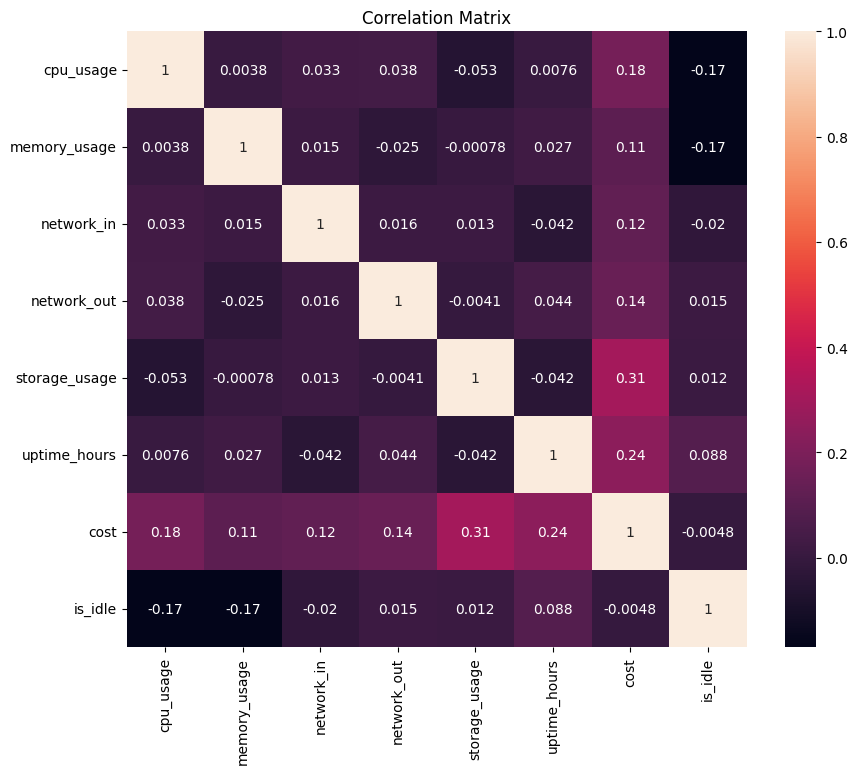

In [48]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Correlation Matrix")
plt.show()


5️⃣ Feature Engineering & Encoding

In [49]:
df_encoded = pd.get_dummies(df, drop_first=True)

X_reg = df_encoded.drop(['cost', 'is_idle'], axis=1)
y_reg = df_encoded['cost']


6️⃣ Train-Test Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


7️⃣ High-Performance Cost Prediction Model (Regression)

In [51]:
rf_reg = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.9702152422764558
MAE: 14.601270368379378
RMSE: 19.651217872708347


8️⃣ Cross-Validation

In [52]:
cv_scores = cross_val_score(rf_reg, X_reg, y_reg, cv=5, scoring='r2')
print("Cross Validation R2 Mean:", cv_scores.mean())


Cross Validation R2 Mean: 0.9720963094748057


9️⃣ Idle Resource Detection Model (Classification)

In [53]:
X_cls = df_encoded.drop(['cost', 'is_idle'], axis=1)
y_cls = df_encoded['is_idle']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

rf_cls = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_cls.fit(X_train_c, y_train_c)

cls_pred = rf_cls.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, cls_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_c, cls_pred))
print("\nClassification Report:\n", classification_report(y_test_c, cls_pred))


Accuracy: 0.98

Confusion Matrix:
 [[392   0]
 [  8   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       392
           1       0.00      0.00      0.00         8

    accuracy                           0.98       400
   macro avg       0.49      0.50      0.49       400
weighted avg       0.96      0.98      0.97       400



🔟 Cost Savings Simulation

In [54]:
idle_instances = df[df['is_idle'] == 1]
estimated_savings = idle_instances['cost'].sum()

print("Estimated Monthly Savings if Idle Resources Removed:", estimated_savings)


Estimated Monthly Savings if Idle Resources Removed: 7637.356559579729


1️⃣1️⃣ Model Saving

In [55]:
joblib.dump(rf_reg, "cost_model.pkl")
joblib.dump(rf_cls, "idle_model.pkl")


['idle_model.pkl']

In [56]:
# ==============================
# SAVE ALL IMPORTANT OUTPUTS
# ==============================

# 1. Save dataset
df.to_csv("cloud_dataset_2000.csv", index=False)

# 2. Save encoded dataset
df_encoded.to_csv("cloud_dataset_encoded.csv", index=False)

# 3. Save regression predictions
reg_results = pd.DataFrame({
    "Actual_Cost": y_test,
    "Predicted_Cost": y_pred
})
reg_results.to_csv("regression_results.csv", index=False)

# 4. Save classification predictions
cls_results = pd.DataFrame({
    "Actual_Idle": y_test_c,
    "Predicted_Idle": cls_pred
})
cls_results.to_csv("classification_results.csv", index=False)

# 5. Save performance summary
performance_summary = pd.DataFrame({
    "Metric": [
        "R2 Score",
        "MAE",
        "RMSE",
        "Cross Validation R2 Mean",
        "Classification Accuracy"
    ],
    "Value": [
        r2_score(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        cv_scores.mean(),
        accuracy_score(y_test_c, cls_pred)
    ]
})

performance_summary.to_csv("model_performance_summary.csv", index=False)

# 6. Save models
joblib.dump(rf_reg, "cost_model.pkl")
joblib.dump(rf_cls, "idle_model.pkl")

print("All files saved successfully!")


All files saved successfully!


In [57]:
# ==============================
# DOWNLOAD ALL FILES
# ==============================

from google.colab import files

files.download("cloud_dataset_2000.csv")
files.download("cloud_dataset_encoded.csv")
files.download("regression_results.csv")
files.download("classification_results.csv")
files.download("model_performance_summary.csv")
files.download("cost_model.pkl")
files.download("idle_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>